<a href="https://colab.research.google.com/github/patchu-madathil/FastAI/blob/master/camvidimagesegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Camvid Image Segmentation


In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

path = untar_data(URLs.CAMVID)
path.ls()




[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [2]:
label_path = path/'labels'
image_path = path/'images'


image_files = get_image_files(image_path)
label_files = get_image_files(label_path)

image_files[:4]





[PosixPath('/root/.fastai/data/camvid/images/0016E5_06390.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01380.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01770.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08005.png')]

In [3]:
label_files[:4]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_08145_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01500_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05520_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01230_P.png')]

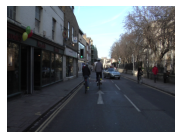

In [4]:
image_name = image_files[4]
open_image(image_name).show()


In [0]:
get_mask_fn = lambda x:label_path/f'{x.stem}_P{x.suffix}'

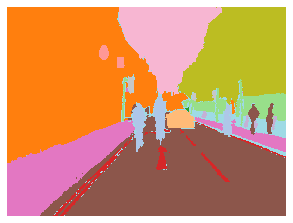

In [6]:
mask = open_mask(get_mask_fn(image_name))
mask.show(figsize=(5,5), alpha=1)




In [0]:
src_size = np.array(mask.shape[1:])

In [8]:
src_size

array([720, 960])

In [9]:
mask.data

tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [11]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Create and load batch

In [0]:
if(gpu_mem_get_free_no_cache() > 8200 ): bs = 8
else:                                   bs = 4
size = src_size//2

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target!=void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
  



In [0]:
src = SegmentationItemList.from_folder(image_path).split_by_fname_file("../valid.txt").label_from_func(get_mask_fn, classes=codes)

In [0]:
data = src.transform(get_transforms(), size = size, tfm_y = True).databunch(bs=bs).normalize(imagenet_stats)
imagenet_stats??


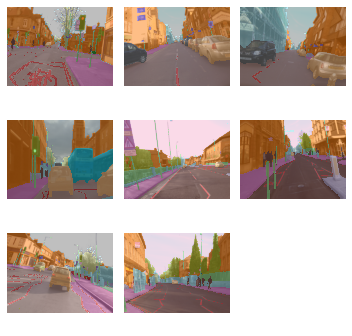

In [16]:
data.show_batch(figsize = (5,5))

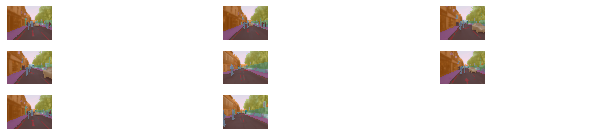

In [17]:
data.show_batch(figsize = (10,2), ds_type=DatasetType.Valid)

In [18]:
metric = acc_camvid
learner = unet_learner(data, models.resnet34, metrics = metric)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [19]:
lr_find(learner)


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


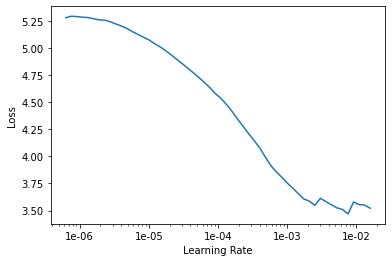

In [20]:
learner.recorder.plot()

In [21]:

learner.lr_find()


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


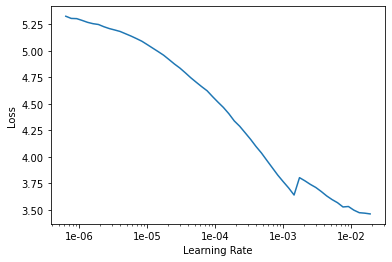

In [22]:
learner.recorder.plot()

In [23]:
lr = 1e-3
learner.fit_one_cycle(10,slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.640988,1.033230,0.759000,03:12
1,0.994344,0.643223,0.835928,03:06
2,0.745927,0.591344,0.854327,03:06
3,0.641789,0.484213,0.871047,03:05
4,0.550935,0.455061,0.874454,03:05
5,0.489316,0.382458,0.888856,03:05
6,0.440322,0.377050,0.889755,03:05
7,0.397137,0.317651,0.908129,03:05
8,0.359451,0.307271,0.907989,03:05
9,0.340230,0.298101,0.911502,03:05


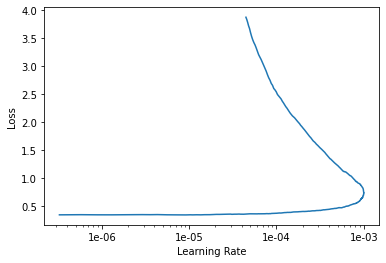

In [24]:
learner.recorder.plot()

In [0]:
learner.save('stage-1')

In [0]:
learner.unfreeze()

In [0]:
lrs = 1e-4


In [28]:
learner.fit_one_cycle(7,slice(lrs))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.327592,0.296564,0.914528,03:13
1,0.334830,0.323949,0.901631,03:13
2,0.330822,0.286880,0.917396,03:13
3,0.310699,0.299978,0.907069,03:13
4,0.296774,0.280406,0.919861,03:13
5,0.282889,0.279443,0.919229,03:13
6,0.279145,0.271831,0.922139,03:13


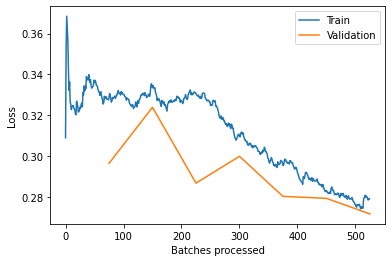

In [30]:
learner.recorder.plot_losses()

In [0]:
fbeta??